Data Collection using Kaggle Dataset for Retail Receipts

In [2]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ocr-receipts-text-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3753245%2F6494011%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240309%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240309T142721Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5aeed51c811437c000caea59ac428a5a1da90f9b65e91d6daeefd8ce429053b8c7d647812ec0896a1fb581a41e09583d6e00b27c66986cc8ebd4e6d68e8a4909e8fa8717742e7835a73a789558001a6f4c4c93283b9415002aff37cb285a4380cc462fc3da2309c3300c033312ca6d960002c8888810cc0b137d5e3867314a3879e5bc86ec69ca0ccd180061b5c1e71df5af1c0af30e26691ee0eb14366199e870a4e3fe0721a0c76e701f54e0a7558821f3a83745506f0eba2e2e81307a653dc537d1e10301f1a862edf8733887af629e4d543105152a8c5254f00f7314ea7e7a62d9cad6b1ca5303a0ce97fada44948bbb7d7dbfa846dd567d13e42d328f2f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 55182311 bytes downloaded
Downloaded and uncompressed: ocr-receipts-text-detection
Data source import complete.


In [3]:
pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 31.1 MB/s eta 0:00:00


In [4]:
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import os
from bs4 import BeautifulSoup
import torch
from keras import layers
from keras.models import Model
from sklearn.model_selection import train_test_split

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
W,H = 320, 320

**Data Pre-processing using Gaussian Threshold**


>For data Pre-processing, I've used Gaussian Threshold method and customised my dataset and stored the processed images locally and then uploaded them to the drive

In [ ]:
import os
import cv2

def gaussian_threshold(image_path, output_folder, threshold_value=55, max_value=255):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Gaussian thresholding
    _, thresholded_image = cv2.threshold(image, threshold_value, max_value, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Save the thresholded image
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, thresholded_image)

def gaussian_threshold_all_images(input_folder, output_folder, threshold_value=55, max_value=255):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Process each image in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Adjust as per your image types
            image_path = os.path.join(input_folder, filename)
            gaussian_threshold(image_path, output_folder, threshold_value, max_value)

# Example usage:
input_folder = 'BIllReceiptImageCollection'
output_folder = 'outputfolder'
gaussian_threshold_all_images(input_folder, output_folder, threshold_value=127, max_value=255)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Use pre-processed images for model training

In [31]:
data_path = '/content/drive/MyDrive/imgsocr/imgs'
box_path = '/kaggle/input/ocr-receipts-text-detection/boxes'
xml_path = '/kaggle/input/ocr-receipts-text-detection/annotations.xml'
east_path = '/kaggle/input/east-model/frozen_east_text_detection.pb'

In [32]:
determined_labels = {'shop': 0, 'item': 1, 'total': 2, 'date_time': 3, 'other': 4}

In [33]:
class ExtractingText:

    def __init__(self, solution: str, usingGPU: bool):

        self.gpu = usingGPU
        if 'Terr' or 'Easy' in solution:
            self.sol = solution
        else:
            print(f"Solution must be 'Tess' or Easy")


    def cleanup_text(self, text):
        # strip out non-ASCII text so we can draw the text on the image
        # using OpenCV
        return "".join([c if ord(c) < 128 else "" for c in text]).strip()

    """
    Tesseract
    """
    def Tesseract(self, dtset, min_length):
        if 'Tess' in self.sol:
            import pytesseract
            from PIL import Image

            char = []
            for idx in dtset:
                z = []
                image = Image.open(os.path.join(data_path, idx))
                data = pytesseract.image_to_data(image,
                                                 output_type=pytesseract.Output.DICT)

                for i in range(len(data['text'])):
                    text = data['text'][i]
                    text = self.cleanup_text(text)
                    if len(text) < min_length: continue
                    z.append([text])

                char.append([idx, z])
            return char

        else:
            print("Solution must be 'Tess'")

    def get_results(self, ocr_results, de_prob):
        words = []
        for (bbox, text, prob) in ocr_results:
            if prob > de_prob and len(text)>2:
                text = self.cleanup_text(text)  # Assuming cleanup_text is defined elsewhere
                words.append([text])
        return words

    def EasyOCR(self, dtset, languages, de_prob=0.5):
        if 'Easy' in self.sol:
            from easyocr import Reader
            char_pos = []
            for idx in dtset:
                img_file = os.path.join(data_path, os.path.basename(idx))
                img = cv2.imread(img_file)
                reader = Reader([languages], gpu=self.gpu)
                results = reader.readtext(img)
                bboxes = self.get_results(results, de_prob)
                char_pos.append([idx, bboxes])
            return char_pos
        else:
            print("Solution must be 'Easy'")


In [34]:
extract_text = ExtractingText('Easy', True)
word_position = extract_text.EasyOCR(sorted(os.listdir(data_path)), 'en', de_prob=0.2)

In [35]:
def get_data(annotation_file, ext_word, split_rate=0.2):

    dt_set = []

    with open(annotation_file, 'r') as f:
            data = f.read()
    Bs_data = BeautifulSoup(data, "xml")
    infors = Bs_data.find_all('image')

    for i, idx in enumerate(infors):
        k = []
        z = []
        org_dt = []
        name_file = idx.get('name')
        result = [inner_list[0] for inner_list in ext_word[i][1]]
        boxes = idx.find_all('box')

        for box in boxes:
            attribute_element = box.find('attribute', {'name': 'text'})
            text_content = attribute_element.text if attribute_element else None
            label = box.get('label')
            k.append((text_content, label))
            z.append([text_content, label])
            org_dt = z.copy()

        for x in result:
            match_found = False
            for i, j in k:
                if x in i:
                    z.append([x, j])
                    match_found = True
                    break  # Exit the inner loop once a match is found

            if not match_found:
                z.append([x, 'other'])


        dt_set.append([name_file, z + org_dt])

    train_dt, val_dt = train_test_split(dt_set, test_size=split_rate)

    return train_dt, val_dt

In [36]:
train_ds, val_ds = get_data(xml_path, word_position, split_rate=0.4)

# Using DistilBert to classify Text using NLP

In [37]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import torch.nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [40]:
BATCH_SIZE = 32

In [41]:
def get_NLP_data(ds):

    X=[]; y = []
    for index in train_ds:
        for inf in index[1]:
            text = inf[0]
            label = determined_labels[inf[1]]
            X.append(text)
            y.append(label)

    return X, y

In [42]:
X_train, y_train = get_NLP_data(train_ds)
X_val, y_val = get_NLP_data(val_ds)

In [43]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

train_data = tokenizer(list(X_train), return_tensors="pt", padding=True, truncation=True)
valid_data = tokenizer(list(X_val), return_tensors="pt", padding=True, truncation=True)

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': torch.tensor(self.labels[idx])
        }

# Create dataset and dataloader
train_dataset = SentimentDataset(
    input_ids=train_data['input_ids'],
    attention_mask=train_data['attention_mask'],
    labels=y_train
)

val_dataset = SentimentDataset(
    input_ids=valid_data['input_ids'],
    attention_mask=valid_data['attention_mask'],
    labels=y_val
)

In [44]:
class SaveBestModelCallback:
    def __init__(self, model, save_path):
        self.model = model
        self.save_path = save_path
        self.best_val_loss = float(0.65)

    def __call__(self, val_loss):
        if val_loss > self.best_val_loss:
            print(f"Validation loss improved ({self.best_val_loss:.6f} --> {val_loss:.6f}). Saving model...")
            torch.save(self.model.state_dict(), self.save_path)
            self.best_val_loss = val_loss
        else:
            print(f"Validation loss did not improve ({self.best_val_loss:.6f} --> {val_loss:.6f}).")

In [45]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels = 5)
model = model.to(device)

save_callback = SaveBestModelCallback(model, '/kaggle/working/best_model.pth')
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
from tqdm import tqdm

num_epochs = 30

for epoch in range(num_epochs):
    # Training loop
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    progress_bar = tqdm(enumerate(train_dataloader, 1), total=len(train_dataloader))
    for step, batch in progress_bar:
        batch = {key: value.to(device) for key, value in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = criterion(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predictions = torch.argmax(outputs.logits, dim=1)
        correct = (predictions == batch['labels']).sum().item()
        total_correct += correct
        total_samples += len(batch['labels'])

        # Accumulate loss
        total_loss += loss.item()

        progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs}, Step {step}/{len(train_dataloader)}')
        progress_bar.set_postfix({'Loss': loss.item(), 'Accuracy': correct / len(batch['labels'])})

    # Calculate training statistics for the epoch
    epoch_loss = total_loss / len(train_dataloader)
    epoch_accuracy = total_correct / total_samples

    # Validation loop
    model.eval()
    val_total_loss = 0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        for val_step, val_batch in enumerate(val_dataloader, 1):
            val_batch = {key: value.to(device) for key, value in val_batch.items()}
            val_outputs = model(**val_batch)
            val_loss = criterion(val_outputs.logits, val_batch['labels'])

            # Calculate accuracy
            val_predictions = torch.argmax(val_outputs.logits, dim=1)
            val_correct = (val_predictions == val_batch['labels']).sum().item()
            val_total_correct += val_correct
            val_total_samples += len(val_batch['labels'])

            # Accumulate loss
            val_total_loss += val_loss.item()

    # Calculate validation statistics for the epoch
    val_epoch_loss = val_total_loss / len(val_dataloader)
    val_epoch_accuracy = val_total_correct / val_total_samples

    save_callback(val_epoch_accuracy)

    # Print statistics for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}')

Epoch 1/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.52it/s, Loss=0.621, Accuracy=0.9]


Validation loss improved (0.650000 --> 0.732892). Saving model...
Epoch 1/30, Loss: 1.0637, Accuracy: 0.6744, Val Loss: 0.7538, Val Accuracy: 0.7329


Epoch 2/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.58it/s, Loss=0.55, Accuracy=0.8]


Validation loss improved (0.732892 --> 0.845475). Saving model...
Epoch 2/30, Loss: 0.6444, Accuracy: 0.7914, Val Loss: 0.4456, Val Accuracy: 0.8455


Epoch 3/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.71it/s, Loss=0.433, Accuracy=0.8]


Validation loss improved (0.845475 --> 0.900662). Saving model...
Epoch 3/30, Loss: 0.4237, Accuracy: 0.8499, Val Loss: 0.2661, Val Accuracy: 0.9007


Epoch 4/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.58it/s, Loss=0.251, Accuracy=1]


Validation loss improved (0.900662 --> 0.959161). Saving model...
Epoch 4/30, Loss: 0.3117, Accuracy: 0.9128, Val Loss: 0.1830, Val Accuracy: 0.9592


Epoch 5/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.37it/s, Loss=0.157, Accuracy=0.9]


Validation loss improved (0.959161 --> 0.970199). Saving model...
Epoch 5/30, Loss: 0.1865, Accuracy: 0.9470, Val Loss: 0.1151, Val Accuracy: 0.9702


Epoch 6/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.60it/s, Loss=0.0321, Accuracy=1]


Validation loss improved (0.970199 --> 0.974614). Saving model...
Epoch 6/30, Loss: 0.1340, Accuracy: 0.9658, Val Loss: 0.0905, Val Accuracy: 0.9746


Epoch 7/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.54it/s, Loss=0.0134, Accuracy=1]


Validation loss improved (0.974614 --> 0.983444). Saving model...
Epoch 7/30, Loss: 0.1002, Accuracy: 0.9757, Val Loss: 0.0700, Val Accuracy: 0.9834


Epoch 8/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.53it/s, Loss=0.0189, Accuracy=1]


Validation loss did not improve (0.983444 --> 0.977925).
Epoch 8/30, Loss: 0.0739, Accuracy: 0.9823, Val Loss: 0.0736, Val Accuracy: 0.9779


Epoch 9/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.45it/s, Loss=0.0299, Accuracy=1]


Validation loss did not improve (0.983444 --> 0.974614).
Epoch 9/30, Loss: 0.0892, Accuracy: 0.9735, Val Loss: 0.0707, Val Accuracy: 0.9746


Epoch 10/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.56it/s, Loss=0.0244, Accuracy=1]


Validation loss improved (0.983444 --> 0.985651). Saving model...
Epoch 10/30, Loss: 0.0821, Accuracy: 0.9801, Val Loss: 0.0480, Val Accuracy: 0.9857


Epoch 11/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.62it/s, Loss=0.0118, Accuracy=1]


Validation loss improved (0.985651 --> 0.986755). Saving model...
Epoch 11/30, Loss: 0.0544, Accuracy: 0.9845, Val Loss: 0.0410, Val Accuracy: 0.9868


Epoch 12/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.63it/s, Loss=0.0143, Accuracy=1]


Validation loss did not improve (0.986755 --> 0.984547).
Epoch 12/30, Loss: 0.0515, Accuracy: 0.9823, Val Loss: 0.0461, Val Accuracy: 0.9845


Epoch 13/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.66it/s, Loss=0.0228, Accuracy=1]


Validation loss did not improve (0.986755 --> 0.986755).
Epoch 13/30, Loss: 0.0594, Accuracy: 0.9812, Val Loss: 0.0416, Val Accuracy: 0.9868


Epoch 14/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.65it/s, Loss=0.116, Accuracy=0.9]


Validation loss improved (0.986755 --> 0.987859). Saving model...
Epoch 14/30, Loss: 0.0499, Accuracy: 0.9834, Val Loss: 0.0352, Val Accuracy: 0.9879


Epoch 15/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.72it/s, Loss=0.0115, Accuracy=1]


Validation loss improved (0.987859 --> 0.990066). Saving model...
Epoch 15/30, Loss: 0.0425, Accuracy: 0.9879, Val Loss: 0.0312, Val Accuracy: 0.9901


Epoch 16/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.84it/s, Loss=0.0103, Accuracy=1]


Validation loss did not improve (0.990066 --> 0.988962).
Epoch 16/30, Loss: 0.0375, Accuracy: 0.9868, Val Loss: 0.0322, Val Accuracy: 0.9890


Epoch 17/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.80it/s, Loss=0.091, Accuracy=1]


Validation loss did not improve (0.990066 --> 0.988962).
Epoch 17/30, Loss: 0.0425, Accuracy: 0.9857, Val Loss: 0.0283, Val Accuracy: 0.9890


Epoch 18/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.73it/s, Loss=0.00821, Accuracy=1]


Validation loss did not improve (0.990066 --> 0.987859).
Epoch 18/30, Loss: 0.0414, Accuracy: 0.9868, Val Loss: 0.0302, Val Accuracy: 0.9879


Epoch 19/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.68it/s, Loss=0.00586, Accuracy=1]


Validation loss did not improve (0.990066 --> 0.985651).
Epoch 19/30, Loss: 0.0388, Accuracy: 0.9901, Val Loss: 0.0419, Val Accuracy: 0.9857


Epoch 20/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.75it/s, Loss=0.0269, Accuracy=1]


Validation loss did not improve (0.990066 --> 0.990066).
Epoch 20/30, Loss: 0.0356, Accuracy: 0.9857, Val Loss: 0.0257, Val Accuracy: 0.9901


Epoch 21/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.72it/s, Loss=0.00739, Accuracy=1]


Validation loss did not improve (0.990066 --> 0.990066).
Epoch 21/30, Loss: 0.0293, Accuracy: 0.9890, Val Loss: 0.0258, Val Accuracy: 0.9901


Epoch 22/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.79it/s, Loss=0.00678, Accuracy=1]


Validation loss did not improve (0.990066 --> 0.990066).
Epoch 22/30, Loss: 0.0275, Accuracy: 0.9912, Val Loss: 0.0260, Val Accuracy: 0.9901


Epoch 23/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.76it/s, Loss=0.00445, Accuracy=1]


Validation loss did not improve (0.990066 --> 0.977925).
Epoch 23/30, Loss: 0.0619, Accuracy: 0.9779, Val Loss: 0.0597, Val Accuracy: 0.9779


Epoch 24/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.69it/s, Loss=0.0056, Accuracy=1]


Validation loss did not improve (0.990066 --> 0.988962).
Epoch 24/30, Loss: 0.0613, Accuracy: 0.9801, Val Loss: 0.0318, Val Accuracy: 0.9890


Epoch 25/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.81it/s, Loss=0.00765, Accuracy=1]


Validation loss did not improve (0.990066 --> 0.990066).
Epoch 25/30, Loss: 0.0381, Accuracy: 0.9845, Val Loss: 0.0251, Val Accuracy: 0.9901


Epoch 26/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.79it/s, Loss=0.172, Accuracy=0.9]


Validation loss did not improve (0.990066 --> 0.990066).
Epoch 26/30, Loss: 0.0324, Accuracy: 0.9890, Val Loss: 0.0253, Val Accuracy: 0.9901


Epoch 27/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.68it/s, Loss=0.00576, Accuracy=1]


Validation loss improved (0.990066 --> 0.991170). Saving model...
Epoch 27/30, Loss: 0.0306, Accuracy: 0.9890, Val Loss: 0.0222, Val Accuracy: 0.9912


Epoch 28/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.81it/s, Loss=0.00266, Accuracy=1]


Validation loss did not improve (0.991170 --> 0.991170).
Epoch 28/30, Loss: 0.0251, Accuracy: 0.9901, Val Loss: 0.0219, Val Accuracy: 0.9912


Epoch 29/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.74it/s, Loss=0.00528, Accuracy=1]


Validation loss did not improve (0.991170 --> 0.991170).
Epoch 29/30, Loss: 0.0291, Accuracy: 0.9879, Val Loss: 0.0226, Val Accuracy: 0.9912


Epoch 30/30, Step 29/29: 100%|██████████| 29/29 [00:02<00:00, 11.73it/s, Loss=0.00604, Accuracy=1]


Validation loss did not improve (0.991170 --> 0.991170).
Epoch 30/30, Loss: 0.0254, Accuracy: 0.9890, Val Loss: 0.0210, Val Accuracy: 0.9912


In [47]:
pred_values = []
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels = 5)
try:
    model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
except:
    model = model

for i in X_val:
    test_data = tokenizer(i, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**test_data)
        logits = outputs.logits

    # Convert logits to probabilities and get predicted label
    probabilities = torch.softmax(logits, dim=-1)
    predicted_label = torch.argmax(probabilities, dim=-1).item()

    pred_values.append(predicted_label)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


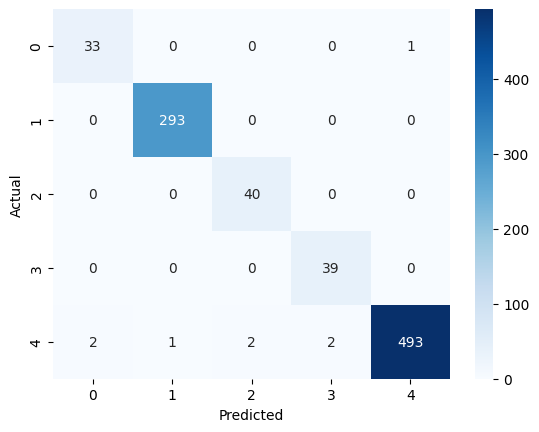

In [48]:
conf_matrix = confusion_matrix(y_val, pred_values)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [49]:
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels = 5)
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [50]:
def easyOCR_results(image, title, min_len):
    from easyocr import Reader
    img = cv2.imread(image)
    reader = Reader(['en'], gpu=True)
    results = reader.readtext(img)

    for (bbox, text, prob) in results:
        if prob > int(min_len/100) and len(text) > min_len:
            (tl, tr, br, bl) = bbox
            tl = (int(tl[0]), int(tl[1]))
            tr = (int(tr[0]), int(tr[1]))
            br = (int(br[0]), int(br[1]))
            bl = (int(bl[0]), int(bl[1]))

            text = extract_text.cleanup_text(text)
            tknz = tokenizer(text, return_tensors="pt")

            with torch.no_grad():
                outputs = model(**tknz)
                logits = outputs.logits

            probabilities = torch.softmax(logits, dim=-1)
            predicted_label = torch.argmax(probabilities, dim=-1).item()

            for label, value in determined_labels.items():
                 if value == predicted_label:
                        text = label

            if 'shop' in text:
                cv2.rectangle(img, tl, br, (255, 0, 0), 2)
                cv2.putText(img, text, (tl[0], tl[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

            elif 'item' in text:
                cv2.rectangle(img, tl, br, (0, 175, 0), 2)
                cv2.putText(img, text, (tl[0], tl[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 175, 0), 2)
            elif 'total' in text:
                cv2.rectangle(img, tl, br, (0, 0, 255), 2)
                cv2.putText(img, text, (tl[0], tl[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

            elif 'other' in text:
                cv2.rectangle(img, tl, br, (0, 0, 0), 2)
                cv2.putText(img, text, (tl[0], tl[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

            else:
                cv2.rectangle(img, tl, br, (255, 175, 0), 2)
                cv2.putText(img, text, (tl[0], tl[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 175, 0), 2)

    plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [51]:
def Tess_results(image, title, min_len):
    import pytesseract
    img = cv2.imread(image)
    data = pytesseract.image_to_data(image,
                                     output_type=pytesseract.Output.DICT)

    for i in range(len(data['text'])):
        text = data['text'][i]
        text = extract_text.cleanup_text(text)
        if len(text) < min_len: continue

        tknz = tokenizer(text, return_tensors="pt")

        with torch.no_grad():
            outputs = model(**tknz)
            logits = outputs.logits

        probabilities = torch.softmax(logits, dim=-1)
        predicted_label = torch.argmax(probabilities, dim=-1).item()

        for label, value in determined_labels.items():
             if value == predicted_label:
                    text = label

        x, y, width, height = int(data['left'][i]), int(data['top'][i]), int(data['width'][i]), int(data['height'][i])

        if 'shop' in text:
            cv2.rectangle(img, (x, y), (x + width, y + height), (255, 0, 0), 2)
            cv2.putText(img, text, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


        elif 'item' in text:
                cv2.rectangle(img, (x, y), (x + width, y + height), (0, 175, 0), 2)
                cv2.putText(img, text, (x, y - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 175, 0), 2)
        elif 'total' in text:
            cv2.rectangle(img, (x, y), (x + width, y + height), (0, 0, 255), 2)
            cv2.putText(img, text, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        elif 'other' in text:
            cv2.rectangle(img, (x, y), (x + width, y + height), (0, 0, 0), 2)
            cv2.putText(img, text, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

        else:
            cv2.rectangle(img, (x, y), (x + width, y + height), (255, 175, 0), 2)
            cv2.putText(img, text, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 175, 0), 2)

    plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [52]:
def display_results(test_dt, method='Easy', min_len=5):
    file_val = [inner_list[0] for inner_list in test_dt]
    if method == 'Easy':
        for idx in file_val:
            img_file = os.path.join(data_path, os.path.basename(idx))
            easyOCR_results(img_file, idx, min_len)

    elif method == 'Tess':
        for idx in file_val:
            img_file = os.path.join(data_path, os.path.basename(idx))
            Tess_results(img_file, idx, min_len)

    else:
        print("Method must be 'Tess' or 'Easy'")

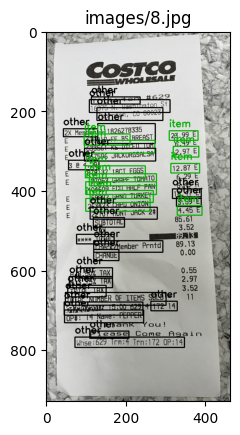

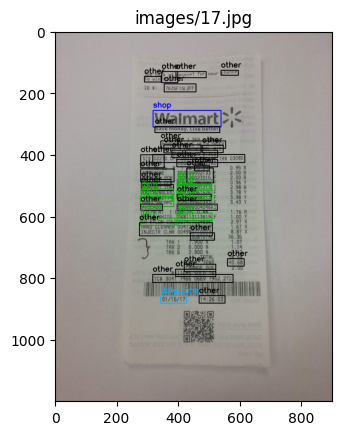

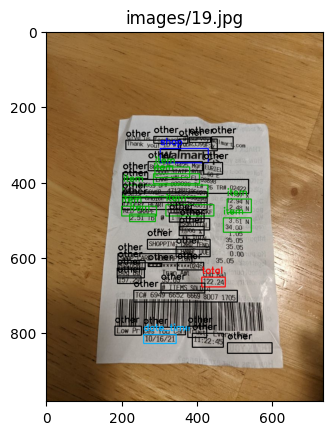

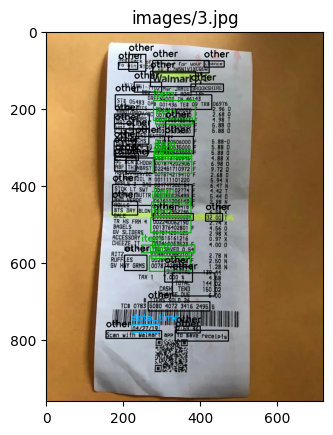

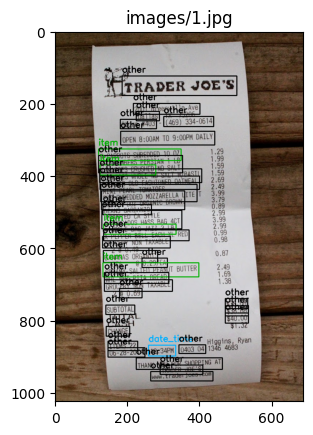

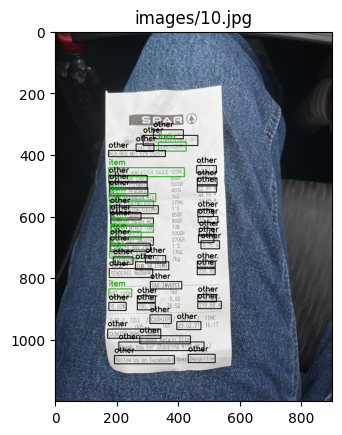

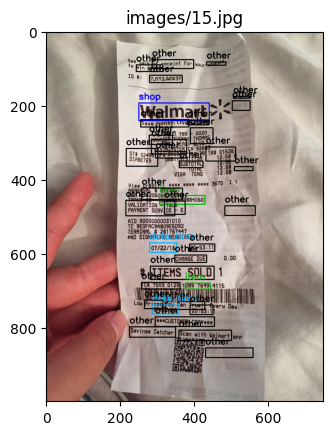

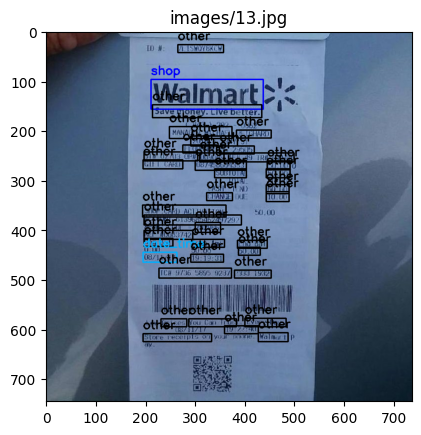

In [53]:
display_results(val_ds, method='Easy', min_len=5)

# Donut Model

In [67]:
pip install -q transformers datasets sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00


In [68]:
pip install -q pytorch-lightning wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.8/258.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00


In [69]:
pip install datasets --upgrade

In [70]:
from datasets import load_dataset

dataset = load_dataset("naver-clova-ix/cord-v2")


Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Using DistilBert detecting the text and objectifying to JSON object
>Displaying image for reference

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


{'menu': [{'nm': '12/28/10', 'unitprice': '7:54', 'cnt': 'PN', 'price': '7:54'}, {'nm': 'Trivento', 'unitprice': '7:54', 'cnt': '24', 'price': '88.00'}, {'nm': 'Wodding Soup', 'cnt': {'unitprice': '917.95'}, 'price': '980.000'}, {'nm': 'Fettuccine Alfredo Steak', 'unitprice': '95.9', 'cnt': '1', 'price': '526.95'}], 'sub_total': {'subtotal_price': ['9溫', '526.3'], 'service_price': '4 95', 'tax_price': '34 00'}, 'total': {'total_price': '57.00', 'creditcardprice': '57.00'}}


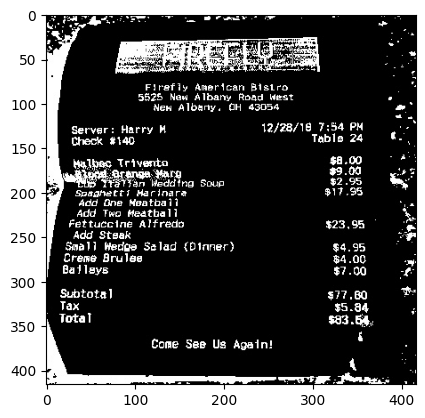

In [72]:
import re

from transformers import DonutProcessor, VisionEncoderDecoderModel
from datasets import load_dataset
import torch
import cv2

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
# load document image
image = cv2.imread('/content/drive/MyDrive/imgsocr/imgs/receipt_image_110.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# prepare decoder inputs
task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

pixel_values = processor(image, return_tensors="pt").pixel_values

outputs = model.generate(
    pixel_values.to(device),
    decoder_input_ids=decoder_input_ids.to(device),
    max_length=model.decoder.config.max_position_embeddings,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(processor.token2json(sequence))

Code to save the detections in JSON File

In [74]:
import re
import json
from transformers import DonutProcessor, VisionEncoderDecoderModel
from datasets import load_dataset
import torch
import cv2

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load document image
image_path = '/content/drive/MyDrive/imgsocr/imgs/receipt_image_110.jpg'
image = cv2.imread(image_path)

# Prepare decoder inputs
task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

# Process the image
pixel_values = processor(image, return_tensors="pt").pixel_values

# Generate sequence
outputs = model.generate(
    pixel_values.to(device),
    decoder_input_ids=decoder_input_ids.to(device),
    max_length=model.decoder.config.max_position_embeddings,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

# Decode the sequence
sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token

print("boxes:",sequence)


# # Save bounding box coordinates and sequence in JSON
output_data = {"sequence": sequence}
output_json_path = '/content/drive/MyDrive/imgsocr/output/output.json'
with open(output_json_path, 'w') as json_file:
    json.dump(output_data, json_file)

print("Output image with bounding boxes and JSON file saved successfully.")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


boxes: <s_menu><s_nm> 12/28/10</s_nm><s_unitprice> 7:54</s_unitprice><s_cnt> PN</s_cnt><s_price> 7:54</s_price><sep/><s_nm> Trivento</s_nm><s_unitprice> 7:54</s_unitprice><s_cnt> 24</s_cnt><s_price> 88.00</s_price><sep/><s_nm> Wodding Soup</s_nm><s_unitprice> Marinaro</s_nm><s_unitprice> 917.95</s_unitprice><s_cnt> Add tme Moatbali</s_nm><s_unitprice> 917.95</s_unitprice><s_cnt> 1</s_cnt><s_price> 980.000</s_price><sep/><s_nm> Fettuccine Alfredo Steak</s_nm><s_unitprice> 95.9</s_unitprice><s_cnt> 1</s_cnt><s_price> 526.95</s_price></s_menu><s_sub_total><s_subtotal_price> 9溫<sep/> 526.3</s_subtotal_price><s_service_price> 4 95</s_service_price><s_tax_price> 34 00</s_tax_price></s_sub_total><s_total><s_total_price> 57.00</s_total_price><s_creditcardprice> 57.00</s_creditcardprice></s_total>
Output image with bounding boxes and JSON file saved successfully.



**API Code for inference**



In [1]:
import os
import re
import json
from flask import Flask, request, jsonify
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import cv2

app = Flask(__name__)

# Load model and processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

@app.route('/api/extract_sequence', methods=['POST'])
def extract_sequence():
    # Check if image file is present in the request
    if 'image' not in request.files:
        return jsonify({'error': 'No image provided'}), 400

    # Get the image file from the request
    image_file = request.files['image']

    # Save the image temporarily
    temp_image_path = 'temp_image.jpg'
    image_file.save(temp_image_path)

    # Load the image
    image = cv2.imread(temp_image_path)

    # Prepare decoder inputs
    task_prompt = "<s_cord-v2>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # Process the image
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # Generate sequence
    with torch.no_grad():
        outputs = model.generate(
            pixel_values.to(device),
            decoder_input_ids=decoder_input_ids.to(device),
            max_length=model.decoder.config.max_position_embeddings,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # Decode the sequence
    sequence = processor.batch_decode(outputs.sequences)[0]
    sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token

    # Remove the temporary image file
    os.remove(temp_image_path)

    # Create JSON response
    response = {'sequence': sequence}
    return jsonify(response)

if __name__ == '__main__':
    app.run(debug=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.02M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/806M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
